# Actuary task
## Bálint Maróti

### Import libraries

In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from arch import arch_model
from sklearn.decomposition import PCA
from datetime import date
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm


### Importing the data and basic preprocessing


In [2]:
df = (
    pd.read_csv("data/benchmark_pivot.csv", parse_dates=["date"])
      .set_index("date")
      .sort_index()
)
df_bps = df * 100 # Converted to basis points
assert df_bps.isna().sum().sum() == 0, "Unexpected NaNs"
display(df_bps.head())

,3M,6M,1Y,3Y,5Y,10Y,15Y
date,,,,,,,
2002-01-03,965.0,939.0,896.0,807.0,758.0,698.0,665.0
2002-01-04,959.0,936.0,894.0,798.0,748.0,696.0,660.0
2002-01-07,941.0,922.0,881.0,786.0,739.0,687.0,651.0
2002-01-08,913.0,898.0,876.0,784.0,734.0,686.0,653.0
2002-01-09,910.0,900.0,875.0,780.0,733.0,689.0,653.0


### Basic EDA with the help of OpenAI o3

In [3]:
df_bps.describe().T

,count,mean,std,min,25%,50%,75%,max
3M,5836.0,519.820255,377.709087,-12.0,95.00,588.0,790.25,1494.0
6M,5836.0,526.530843,382.542004,-5.0,94.00,590.0,798.00,1547.0
1Y,5836.0,532.384339,377.962901,-5.0,100.00,598.0,800.00,1464.0
3Y,5836.0,565.669808,327.817849,17.0,198.00,658.0,800.00,1438.0
5Y,5836.0,574.557916,282.966437,69.0,266.00,667.0,773.00,1344.0
10Y,5836.0,590.832248,223.621015,147.0,347.75,665.0,744.00,1247.0
15Y,5836.0,598.648903,195.303617,183.0,388.00,657.0,734.00,1165.0


In [4]:
# locate potential bad lines
bad = df_bps[(df_bps < 0).any(axis=1)]
display(bad)

,3M,6M,1Y,3Y,5Y,10Y,15Y
date,,,,,,,
2017-09-11,-1.0,0.0,0.0,59.0,153.0,285.0,348.0
2017-09-12,-1.0,1.0,0.0,59.0,153.0,288.0,349.0
2017-09-14,-1.0,-1.0,0.0,56.0,142.0,285.0,346.0
2017-09-15,-2.0,-1.0,0.0,55.0,139.0,283.0,344.0
2017-09-18,-3.0,-1.0,0.0,52.0,136.0,282.0,345.0
...,...,...,...,...,...,...,...
2020-01-28,3.0,-1.0,6.0,46.0,128.0,210.0,271.0
2020-01-29,3.0,-1.0,6.0,51.0,135.0,216.0,277.0
2020-01-30,3.0,-1.0,8.0,49.0,133.0,209.0,272.0


Hungary’s Government Debt Management Agency (ÁKK) did in fact auction 3-month discount Treasury bills at slightly negative yields in 2017–2018 after the MNB pushed the overnight deposit rate below zero. At the 5 September 2017 auction, for example, the average yield printed −0.02 % (≈ −2 bp) and subsequent auctions stayed in the red for several weeks. 
Kormany - ChatGPT - o3

3M     196
6M     107
1Y      87
3Y       0
5Y       0
10Y      0
15Y      0
dtype: int64


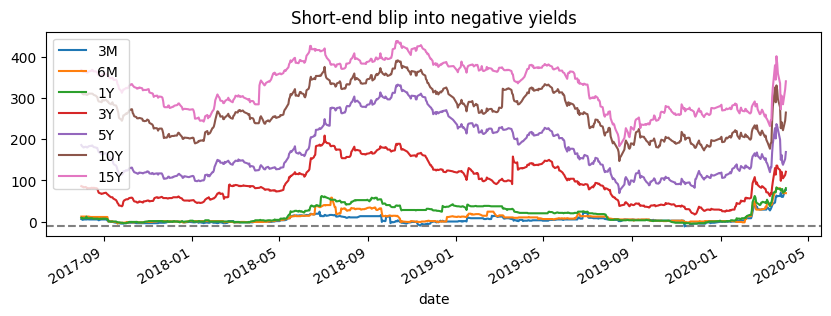

In [5]:
# How many datapoints are below zero?
neg_counts = (df_bps < 0).sum()
print(neg_counts)

# Visualise the period
df_bps["2017-08":"2020-03"].plot(figsize=(10,3), title="Short-end blip into negative yields")
plt.axhline(-10, color="gray", ls="--")
plt.show()

In [6]:
floor_bp = 0 # Set the floor for basis points
# Apply the floor to the basis points data
df_bps_level = df_bps.clip(lower=floor_bp)
# this will be used when i convert back to decimal rates for pricing(rate_dec = rate_bp / 10000)

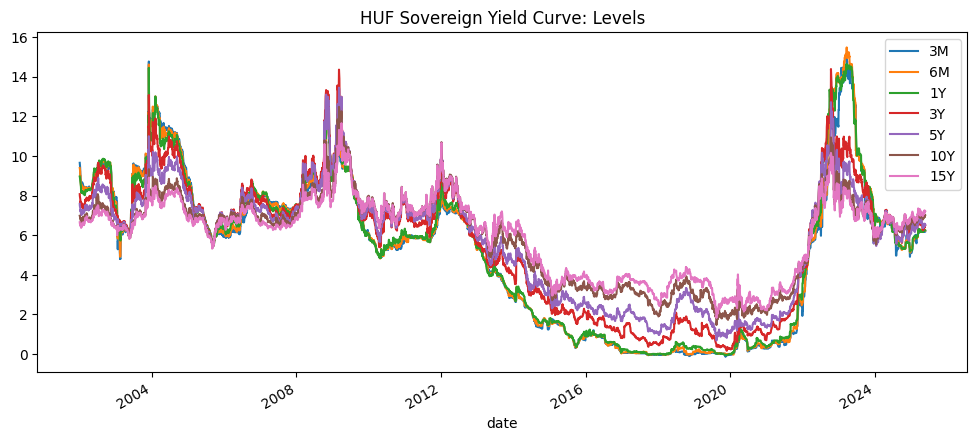

In [7]:
df.plot(figsize=(12,5), title="HUF Sovereign Yield Curve: Levels")
plt.show()

###  Reading the HUF yield-curve history – key regimes & what drove them  

| Period | What you see on the plot | Macro / market driver | Evidence |
|--------|-------------------------|-----------------------|----------|
| **2002 – 2004**<br>“Early-EU entry jitters” | Volatile 8-10 % across the curve with two sharp spikes (≈ 2003 & early 2004) | ‣ Speculative attacks on the forint before EU accession.<br>‣ NBH hiked the base rate to **12.5 %** in 2003 to defend the currency. | NBH base-rate archive  |
| **Oct 2008 – mid-2009**<br>“Global Financial Crisis & IMF bailout” | 10Y shoots above **14 %**, belly > 13 % | ‣ Foreign-funding stop; FX loans blew up bank balance sheets.<br>‣ IMF/EU rescue package signed Oct 2008. | “The Hungarian Crisis”, EEAG Report 2012  |
| **2011 – 2012**<br>“Euro-area debt spill-over” | Second-tier hump (10-12 %) | Risk-premium repricing across CEE as the Euro-area periphery wobbled. |
| **2013 – 2017**<br>“NBH ultra-easing” | Yields trend relentlessly lower; <br>short end flips **slightly negative (-3 bp)** Aug-Oct 2017 | ‣ Base rate cut from **7 % → 0.9 %**; Funding-For-Growth & BUBOR cap.<br>‣ ÁKK 3-month T-bills auctioned at sub-zero yields. | NBH rate log ; Portfolio.hu |
| **Mar 2020 – Q1 2021**<br>“Covid QE & liquidity backstop” | Brief knee-jerk uptick, then long end falls **20-60 bp** | ‣ MNB launches HUF **government-bond purchase programme** (Apr 2020).<br>‣ Flattening of 5-15Y segment as APP ramps up. | BIS case-study on EM QE ; NBH press release (May 2020)  |
| **2021 H2 – Oct 2022**<br>“Inflation shock & aggressive hikes” | Curve explodes – 10Y touches **> 10 %**, short end > 14 % in late ’22 | ‣ CPI peaks > 20 % y/y; NBH lifts base rate to **13 %**.<br>‣ FX sell-off amplifies local-currency yields. | Eurostat long-bond series: 10Y avg **7.57 %** in 2022  |
| **Nov 2022 – 2025**<br>“Dis-inflation & cautious easing” | Steep drop toward 6-7 % but still well above the pre-Covid lows | ‣ Price caps rolled off, CPI falls, NBH starts a gradual cut cycle (base rate **6.5 %** by Sept 2024). | NBH base-rate update Sept 2024  |

**Take-aways for modelling**

* Tail events are regime-dependent – treat 2008/2022 as *separate* blocks in EVT back-testing or use a regime-switching GARCH 
* Monetary-policy announcements (rate corridor & QE) visibly alter *both* level and correlation structure → include policy-dummy variables if you run PCA on level changes. **We will ignore this since it would be out of the scope of this tasks required complexity, if a given calendar could be used, it could enhance the moder(or just overfit more).** 
* The 2017 negative-rate episode is short-lived and tiny (−3 bp) – keep it in Δy modelling but **floor to ≥ 0 bp** when you build discount factors for pricing.  


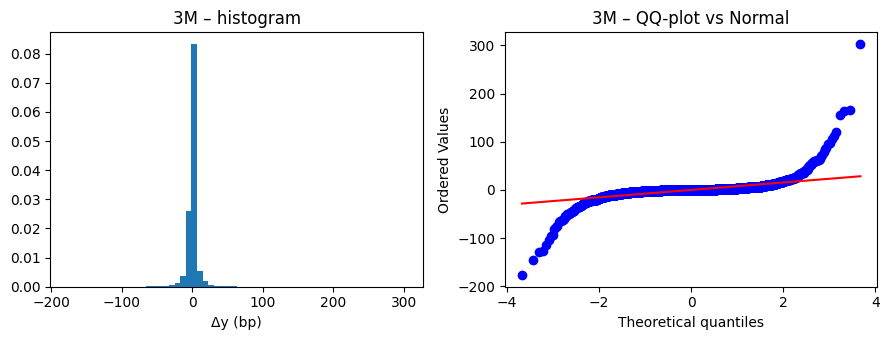

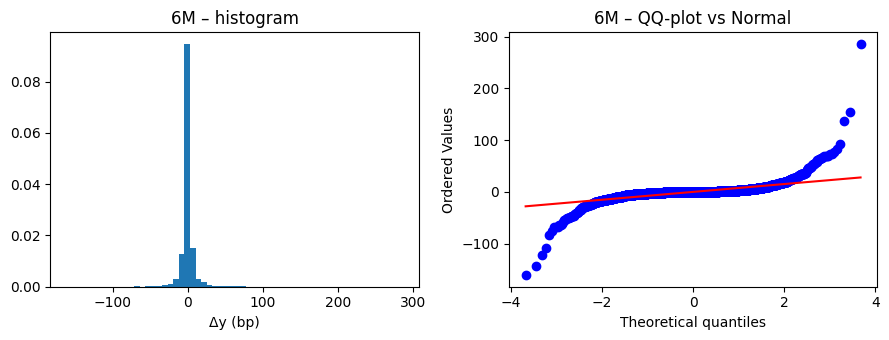

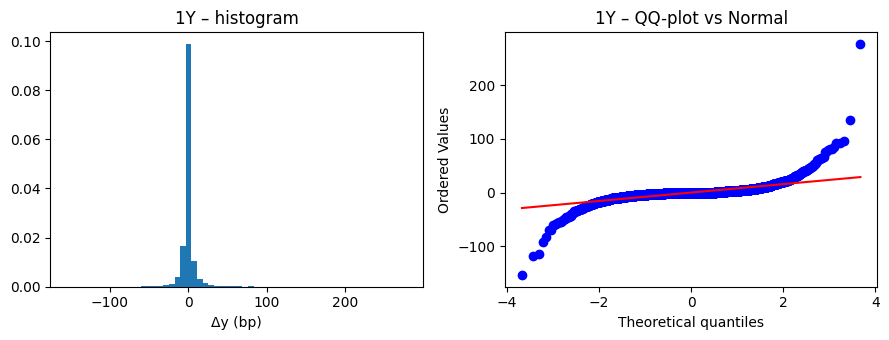

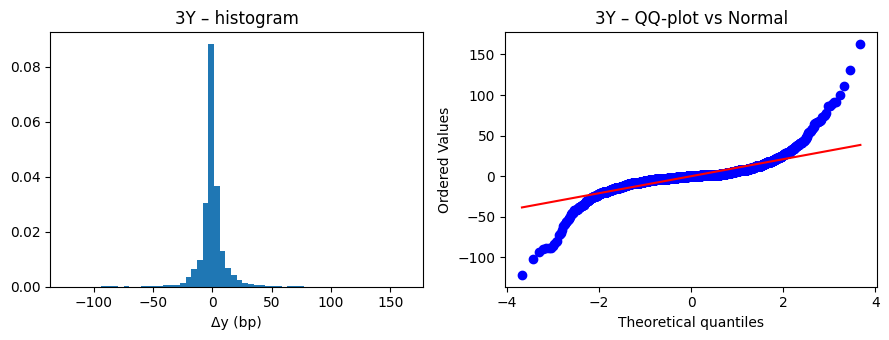

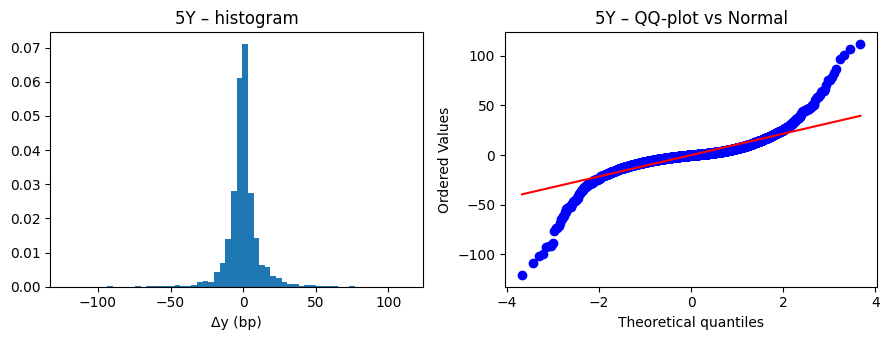

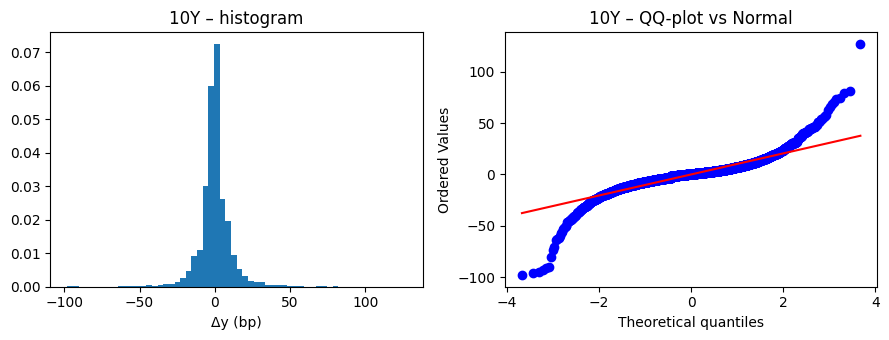

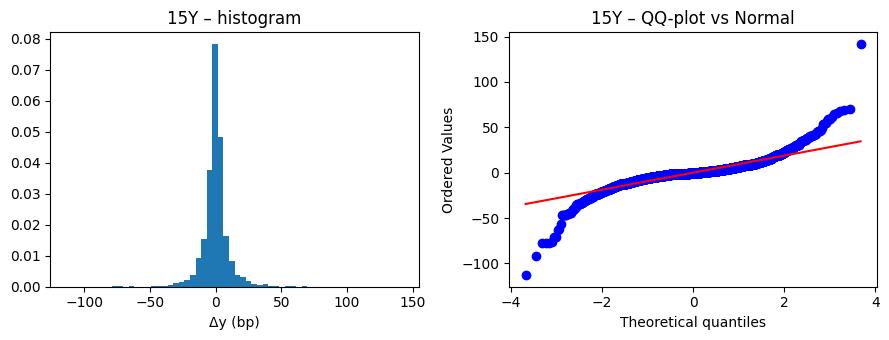

In [8]:
tenors_to_plot = df_bps.columns # ["3M", "1Y", "5Y", "10Y", "15Y"]
deltas = df_bps.diff().dropna()  # Calculate deltas (first differences)
for tenor in tenors_to_plot:
    series = deltas[tenor]

    fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
    # --- Histogram ---
    axes[0].hist(series, bins=60, density=True)
    axes[0].set_title(f"{tenor} – histogram")
    axes[0].set_xlabel("Δy (bp)")
    # --- QQ vs Normal ---
    stats.probplot(series, dist="norm",  plot=axes[1]) # sparams =(5,) if student t
    axes[1].set_title(f"{tenor} – QQ-plot vs Normal")

    plt.tight_layout()
    plt.show()

In [ ]:
# Skewness and Kurtosis
def skew_kurtosis(series):
    return pd.Series({
        "skewness": series.skew(),
        "kurtosis": series.kurtosis()
    })
    
)
skew_kurtosis_df = deltas.apply(skew_kurtosis)
display(skew_kurtosis_df)


,3M,6M,1Y,3Y,5Y,10Y,15Y
skewness,3.615228,3.413393,3.427674,0.789868,-0.030809,-0.070418,0.134891
kurtosis,144.725623,138.141364,119.453274,24.264084,17.186984,14.717648,18.117365


###  Histogram / QQ-plot + moment diagnostics  

| Tenor | **Skewness** | **Excess kurtosis** | what this means |
|-------|-------------:|--------------------:|-----------------|
| 3 M   | +3.62 | 144,7 | extremely right-skewed, ultra-fat tails |
| 6 M   | +3.41 | 138,1 | same pattern |
| 1 Y   | +3.43 | 119,5 | large upside jumps dominate |
| 3 Y   | +0.79 |  24,3 | still right-skew, tails ≫ Normal(0) |
| 5 Y   | −0.03 |  17,2 | nearly symmetric, heavy tails |
| 10 Y  | −0.07 |  14,7 | slight left skew, heavy tails |
| 15 Y  | +0.13 |  18.1 | close to symmetric, heavy tails |

* **Fat tails everywhere** – Gaussian kurtosis is 3; even the calm long end is > 11, short-end kurtosis tops **140**.  
* **Skew switches sign along the curve**  
  * Short tenors (liquidity-driven bills) have **positive skew** → huge upward yield jumps (price drops).  
  * Long tenors show **near-zero or slight negative skew** → downside jumps more common except 15Y

**Visual confirmation**

* Histograms show many more extreme bars than a bell curve.  
* QQ-plots bend away from the straight line in both tails – classic heavy-tail signature.  
* Upper tail of 3 M/6 M departs **much faster** than lower → numeric skew matches the picture.

---

#### Model implication  

| feature to capture | standard Student-t | need upgrade? | recommendation |
|--------------------|--------------------|---------------|----------------|
| Fat-tail kurtosis  | ✔️ handles it via ν | adequate | keep Student-t |
| **Tail asymmetry** | ✖️ symmetric by design | **Yes** for 3 M–1 Y | use **skew-t** innovations *or* add an EGARCH leverage term |
| Volatility clustering | handled in GARCH | ✔️ | retain GARCH(1, 1) |


### Serial correlation ACF and PACF plots


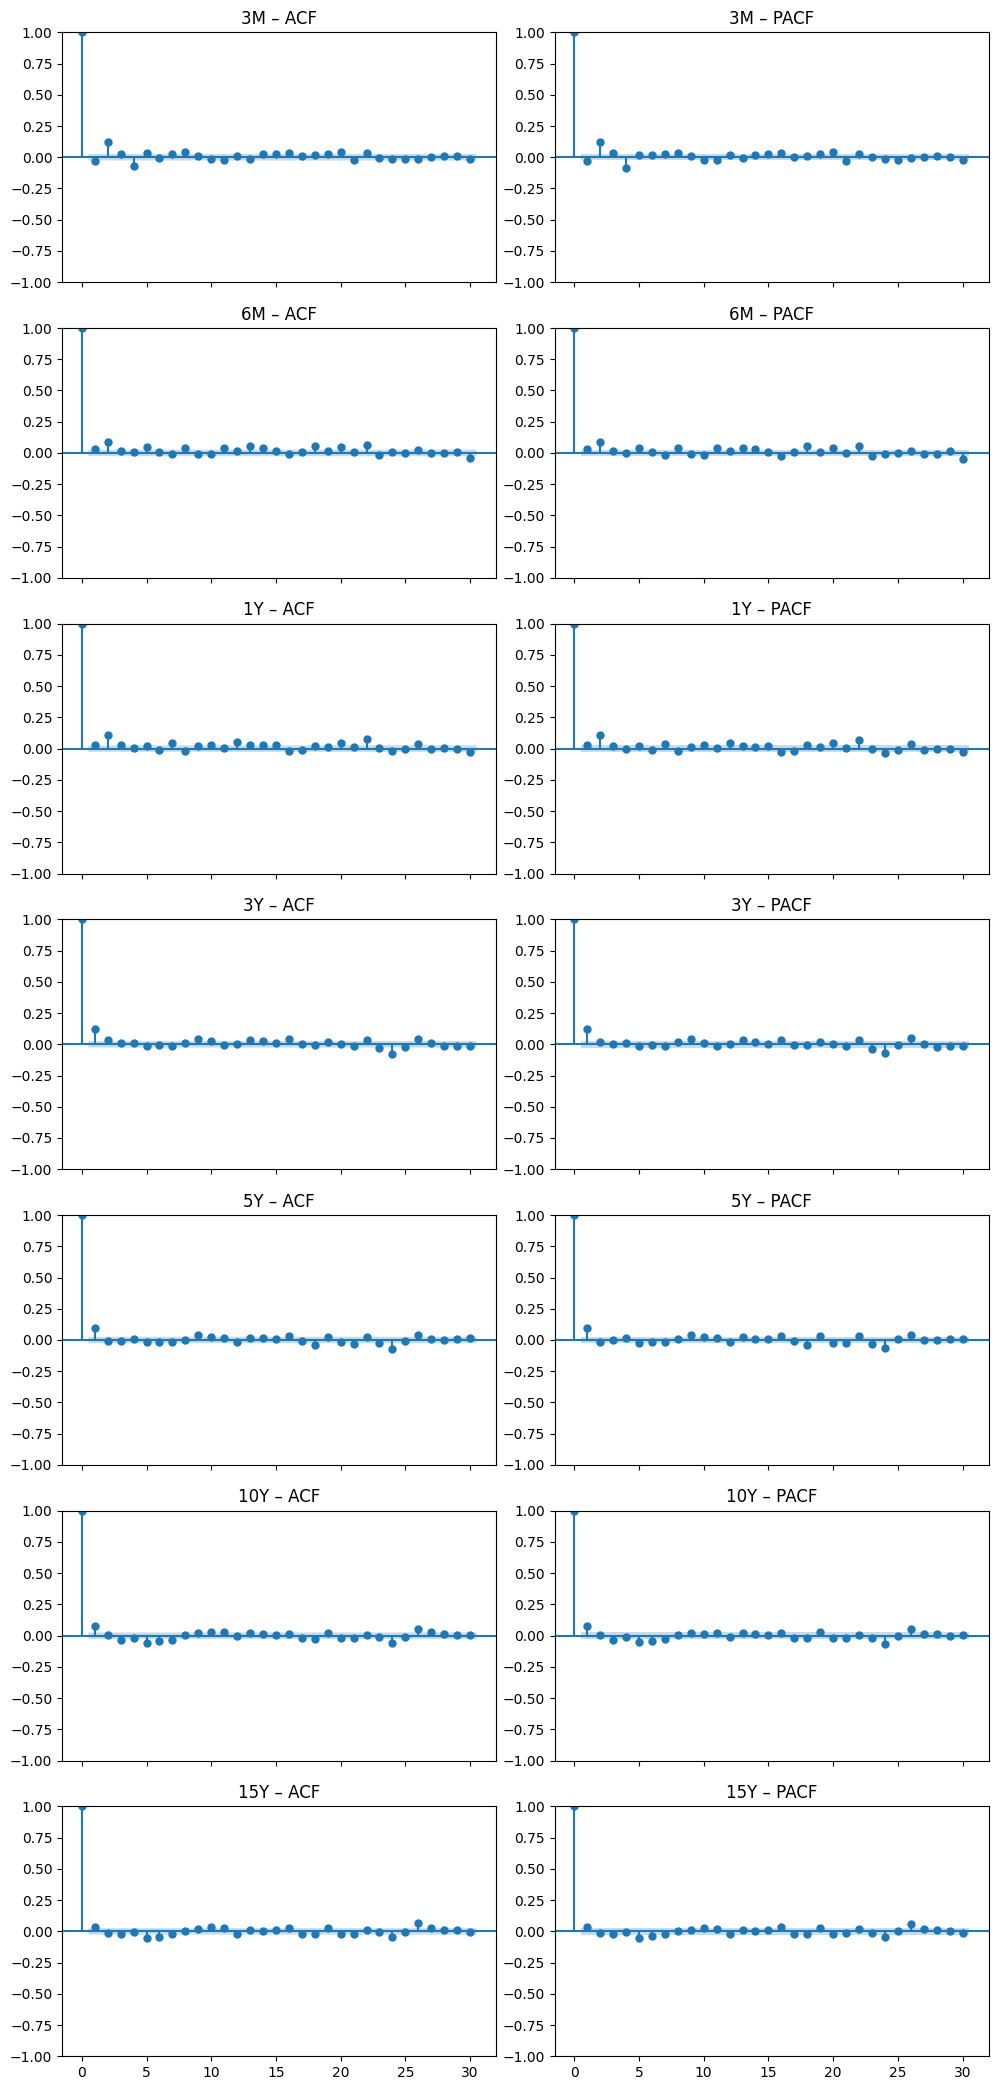

In [10]:
tenors = df_bps.columns
lags = 30

fig, axes = plt.subplots(len(tenors), 2,
                         figsize=(10, 3 * len(tenors)),
                         sharex=True)

for i, tenor in enumerate(tenors):
    plot_acf(deltas[tenor], lags=lags,
             ax=axes[i, 0],
             title=f"{tenor} – ACF")
    plot_pacf(deltas[tenor], lags=lags,
              ax=axes[i, 1],
              title=f"{tenor} – PACF")

plt.tight_layout()
plt.show()


In [11]:
# check for all lags
for i in range(10):
    for tenor in tenors:
        acf_val = acf(deltas[tenor], nlags=lags)
        pacf_val = pacf(deltas[tenor], nlags=lags)
        print(f"{tenor} - ACF({i}): {acf_val[i]:.4f}, PACF({i}): {pacf_val[i]:.4f}")

3M - ACF(0): 1.0000, PACF(0): 1.0000
6M - ACF(0): 1.0000, PACF(0): 1.0000
1Y - ACF(0): 1.0000, PACF(0): 1.0000
3Y - ACF(0): 1.0000, PACF(0): 1.0000
5Y - ACF(0): 1.0000, PACF(0): 1.0000
10Y - ACF(0): 1.0000, PACF(0): 1.0000
15Y - ACF(0): 1.0000, PACF(0): 1.0000
3M - ACF(1): -0.0314, PACF(1): -0.0314
6M - ACF(1): 0.0288, PACF(1): 0.0288
1Y - ACF(1): 0.0262, PACF(1): 0.0262
3Y - ACF(1): 0.1205, PACF(1): 0.1206
5Y - ACF(1): 0.0936, PACF(1): 0.0936
10Y - ACF(1): 0.0773, PACF(1): 0.0773
15Y - ACF(1): 0.0370, PACF(1): 0.0370
3M - ACF(2): 0.1210, PACF(2): 0.1201
6M - ACF(2): 0.0876, PACF(2): 0.0869
1Y - ACF(2): 0.1101, PACF(2): 0.1095
3Y - ACF(2): 0.0342, PACF(2): 0.0199
5Y - ACF(2): -0.0054, PACF(2): -0.0143
10Y - ACF(2): 0.0079, PACF(2): 0.0019
15Y - ACF(2): -0.0101, PACF(2): -0.0115
3M - ACF(3): 0.0271, PACF(3): 0.0348
6M - ACF(3): 0.0182, PACF(3): 0.0135
1Y - ACF(3): 0.0258, PACF(3): 0.0206
3Y - ACF(3): 0.0066, PACF(3): 0.0001
5Y - ACF(3): -0.0041, PACF(3): -0.0023
10Y - ACF(3): -0.0367, P

In [12]:
def aic_ar(series, p):
    mod = sm.tsa.AutoReg(series, lags=p, old_names=False, trend="c").fit()
    return mod.aic

records = []
for tenor in deltas.columns:
    aic1 = aic_ar(deltas[tenor], 1)
    aic2 = aic_ar(deltas[tenor], 2)
    records.append({"tenor": tenor, "AIC_AR(1)": aic1, "AIC_AR(2)": aic2,
                    "ΔAIC": aic2 - aic1})

sel = (pd.DataFrame(records)
         .set_index("tenor")
         .style.format("{:.1f}"))
display(sel)

/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniconda/base/envs/quant/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A dat

,AIC_AR(1),AIC_AR(2),ΔAIC
tenor,,,
3M,44920.6,44828.5,-92.0
6M,44002.5,43952.0,-50.5
1Y,43869.3,43792.9,-76.4
3Y,45542.8,45534.9,-7.9
5Y,45476.1,45469.7,-6.4
10Y,44666.0,44660.7,-5.3
15Y,43748.1,43742.1,-6.0


AR(2) is clearly prefered in 3M 6M and 1Y, while modestly better in the others.

**ΔAIC rule of thumb**  
* ΔAIC ≤ −10 → new model is **decisively** better.  
* −10 < ΔAIC ≤ −2 → new model is **meaningfully** better.  
* |ΔAIC| < 2 → models are statistically indistinguishable – keep the simpler one.


| Option | Pros | Cons |
|--------|------|------|
| **AR(2) on *all* tenors** | Single unified specification; captures mild extra persistence in 3-15 Y segment. | +7 parameters versus AR(1); slightly longer run-time, small risk of over-fitting. |
| **Hybrid:** AR(2) for short end (≤ 1 Y) & AR(1) for ≥ 3 Y | Fewer parameters; keeps model parsimonious where benefit is small. | Two specifications to maintain. |

Choosing AR(2) is the best option, it is also the simplest, we take the risk of overfitting, and address it if it becomes a problem later on.

In [13]:
df.corr().style.background_gradient(cmap="coolwarm", axis=None)

,3M,6M,1Y,3Y,5Y,10Y,15Y
3M,1.000000,0.997872,0.995262,0.967737,0.944421,0.906700,0.882003
6M,0.997872,1.000000,0.997761,0.967652,0.944286,0.906995,0.882275
1Y,0.995262,0.997761,1.000000,0.976571,0.954829,0.918534,0.894407
3Y,0.967737,0.967652,0.976571,1.000000,0.993164,0.970515,0.951737
5Y,0.944421,0.944286,0.954829,0.993164,1.000000,0.987228,0.973010
10Y,0.906700,0.906995,0.918534,0.970515,0.987228,1.000000,0.995288
15Y,0.882003,0.882275,0.894407,0.951737,0.973010,0.995288,1.000000


High pairwise correlations, already seen on the times series plot, that most tenors move together.

### PCA on daily yield-curve changes  


In [ ]:
# PCA
X = StandardScaler().fit_transform(deltas.values)   # shape = (T, 7)
pca = PCA().fit(X)
# Explained variance ratio
explained_variance = pd.Series(pca.explained_variance_ratio_, 
                     index=[f"PC{i+1}" for i in range(len(pca.components_))],
                     name="Explained %")
display(explained_variance.to_frame().style.format("{:.2%}").background_gradient(cmap="Blues"))

,Explained %
PC1,66.31%
PC2,20.37%
PC3,5.17%
PC4,3.50%
PC5,2.96%
PC6,1.02%
PC7,0.67%


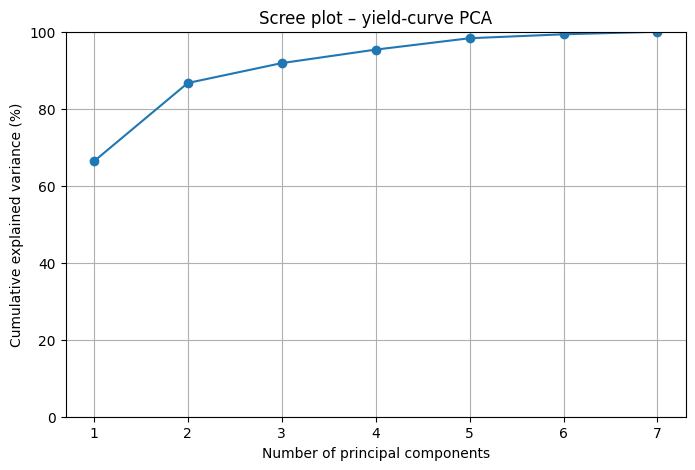

In [15]:
# Scree plot
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), explained_variance.cumsum()*100, marker='o')
plt.xlabel("Number of principal components")
plt.ylabel("Cumulative explained variance (%)")
plt.title("Scree plot – yield-curve PCA")
plt.ylim(0,100); plt.grid(True)
plt.show()

#### Evaluation
* **Parallel shift dominates.**  A single factor accounts for two-thirds of daily Δy.
* **Adding PC2 (twist) lifts coverage to 86 %**, while **PC3 (butterfly) brings us to 91.85 %**.  
* Remaining four PCs each add < 4 % and can be safely ignored for stress-testing.  

**Modelling choice → keep 3 factors.**  
That aligns with both academic literature (Litterman & Scheinkman, 1991) and Solvency II’s three-bucket interest-rate module.  We’ll therefore simulate/stress the curve in a 3-factor space—parallel.


In [ ]:
# Stationarity tests: ADF & KPSS on levels vs first-differences
def adf(series):
    stat, p, *_ = adfuller(series, autolag="AIC") # we use Akaike to select the lag length
    return p

def kpss_(series):
    stat, p, *_ = kpss(series, regression="c", nlags="auto") # this basically means that we use a constant
    return p

records = []
for c in df_bps.columns:
    records.append({
        "Tenor": c,
        "ADF p (level)":  adf(df_bps[c]),
        "KPSS p (level)": kpss_(df_bps[c]),
        "ADF p (Δ)":      adf(deltas[c]),
        "KPSS p (Δ)":     kpss_(deltas[c]),
    })

stn = (pd.DataFrame(records)
         .set_index("Tenor")
         .style.format("{:.3f}")
         .background_gradient(cmap="Reds", axis=None))
display(stn)

/var/folders/mz/0bj7z78d5nn0ncv6217fwn8m0000gn/T/ipykernel_23251/1467659293.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, *_ = kpss(series, regression="c", nlags="auto") # this basically means that we use a constant
/var/folders/mz/0bj7z78d5nn0ncv6217fwn8m0000gn/T/ipykernel_23251/1467659293.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  stat, p, *_ = kpss(series, regression="c", nlags="auto") # this basically means that we use a constant
/var/folders/mz/0bj7z78d5nn0ncv6217fwn8m0000gn/T/ipykernel_23251/1467659293.py:7: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  stat, p, *_ = kpss(series, regression="c"

,ADF p (level),KPSS p (level),ADF p (Δ),KPSS p (Δ)
Tenor,,,,
3M,0.476,0.010,0.000,0.100
6M,0.492,0.010,0.000,0.100
1Y,0.435,0.010,0.000,0.100
3Y,0.372,0.010,0.000,0.100
5Y,0.388,0.010,0.000,0.100
10Y,0.426,0.010,0.000,0.100
15Y,0.393,0.010,0.000,0.100



Statsmodels raises an InterpolationWarning because the KPSS test statistic is outside the look-up table; Python therefore returns 0.01 (lower bound) or 0.10 (upper bound). That still lets us draw clear conclusions:

* **Levels (yields)**  
  * ADF p > 0.05 ⇒ **fail to reject unit-root**.  
  * KPSS p = 0.01 (< 0.05) ⇒ **reject stationarity**.  
  * Together they confirm that each tenor is non-stationary I(1), exactly what we expect for yield levels.

* **First differences (Δy)**  
  * ADF p ≈ 0.000 ⇒ **reject unit-root**.  
  * KPSS p = 0.10 (> 0.05) ⇒ **fail to reject non-stationarity**.  
  * Daily changes are therefore **stationary**.

 **Modelling implication**  
 *Work with Δy.*  We will fit AR(2)-GARCH-t and EVT on those stationary changes, then integrate simulated paths back to levels when we build stressed yield curves for pricing.  
 No additional differencing is required.


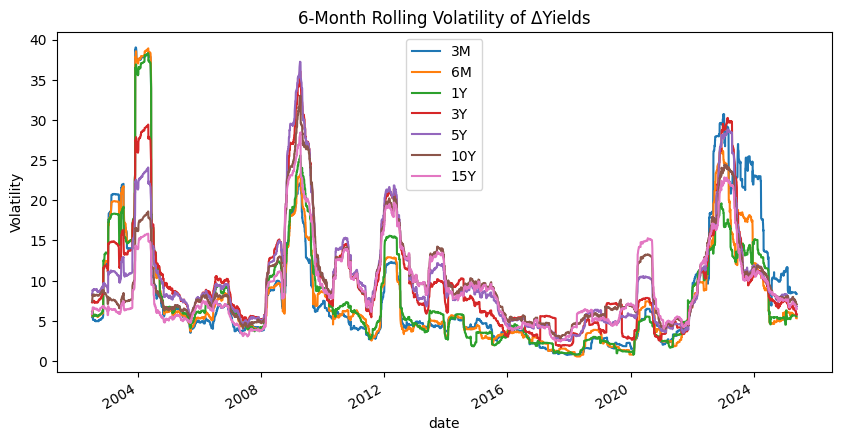

In [28]:
# Rolling volatility
rolling_vol = deltas.rolling(window=126).std()  # approx 6 months
rolling_vol.plot(figsize=(10,5))
plt.title('6-Month Rolling Volatility of ΔYields')
plt.ylabel('Volatility')
plt.show()


In [17]:
for c in deltas.columns:
    lm_stat, lm_pv, f_stat, f_pv = het_arch(deltas[c].values, nlags=5)
    print(f"{c:>3}:  ARCH-LM p-value = {lm_pv:.8f}")
# Copilot

 3M:  ARCH-LM p-value = 0.00000000
 6M:  ARCH-LM p-value = 0.00000000
 1Y:  ARCH-LM p-value = 0.00000000
 3Y:  ARCH-LM p-value = 0.00000000
 5Y:  ARCH-LM p-value = 0.00000000
10Y:  ARCH-LM p-value = 0.00000000
15Y:  ARCH-LM p-value = 0.00000000


### Volatility-clustering test – ARCH-LM results  

*Null hypothesis*: “no ARCH in the residuals.”  
All p-values are effectively zero → we **reject** the null across every tenor.

**Implication for the stress model**  
Each one presents a strong ARCH effect
Volatility is time-dependent.  A static variance estimate is inappropriate; we need a conditional-variance model. We will therefore fit an **AR(2)–GARCH(1, 1) with Skewt and student t innovations** to the daily yield changes before feeding the standardized residuals into the EVT tail module.


### AR(2)–GARCH(1, 1) with skew t on 3m-1y and student t above and EVT tail fitting

In [23]:
SHORT_END = {"3M", "6M", "1Y"}               # skew-t here, t elsewhere
THRESH_Q  = 0.975                             # POT threshold (97,5 %)
P, Q      = 1, 1                             # GARCH orders
AR_LAGS   = 2                                # AR(2) mean

def fit_garch(series, dist_name):
    am = arch_model(
        series,
        mean="AR", lags=AR_LAGS,
        vol="GARCH", p=P, q=Q,
        dist=dist_name
    )
    return am.fit(disp="off", update_freq=0)

def fit_evt(std_resid, thresh_q=THRESH_Q):
    """Return (threshold, shape ξ, scale β) for upper tail."""
    thresh = std_resid.quantile(thresh_q)
    excess = std_resid[std_resid > thresh] - thresh
    xi, loc, beta = stats.genpareto.fit(excess)    # loc ~ 0
    return thresh, xi, beta


In [24]:
garch_fits, evt_params = {}, {}
for tenor in deltas.columns:
    dist = "skewt" if tenor in SHORT_END else "t"
    res  = fit_garch(deltas[tenor], dist)
    garch_fits[tenor] = res
    # EVT on standardised residuals
    thresh, xi, beta = fit_evt(res.std_resid.dropna())
    evt_params[tenor] = {"u": thresh, "xi": xi, "beta": beta}

In [25]:
diag = []
for tenor, res in garch_fits.items():
    pars = res.params
    diag.append({
        "ω":  pars["omega"],
        "α":  pars["alpha[1]"],
        "β":  pars["beta[1]"],
        "α+β":pars["alpha[1]"] + pars["beta[1]"],
        "ν":  pars.get("nu",  None),
        "λ":  pars.get("lambda", None),      # skew-t only
        **evt_params[tenor]
    })
diag_df = pd.DataFrame(diag, index=garch_fits.keys()).round(4)
display(diag_df)

,ω,α,β,α+β,ν,λ,u,xi,beta
3M,0.0000,0.4169,0.5831,1.0,NaN,-0.0001,3.8921,0.9852,2.4909
6M,0.0000,0.3646,0.6354,1.0,NaN,0.0064,3.7010,0.7210,2.1175
1Y,0.0311,0.1558,0.8442,1.0,NaN,0.0066,2.7431,0.2705,1.4726
3Y,0.6908,0.1606,0.8394,1.0,3.4406,NaN,2.3771,0.2899,0.9740
5Y,0.9269,0.1235,0.8765,1.0,3.6882,NaN,2.2784,0.1732,0.8106
10Y,1.5243,0.1322,0.8678,1.0,3.5959,NaN,2.1636,0.2031,0.7206
15Y,1.0802,0.1263,0.8737,1.0,3.4531,NaN,2.1775,0.2268,0.7585


In [26]:
# --- Full-precision view to confirm nothing is exactly on the boundary ----
for tenor, res in garch_fits.items():
    p = res.params
    print(f"{tenor:>3}:  ω={p['omega']:.6e},  α={p['alpha[1]']:.6f},  "
          f"β={p['beta[1]']:.6f},  α+β={p['alpha[1]']+p['beta[1]']:.6f},  "
          f"ν={p.get('nu', np.nan):.3f},  λ={p.get('lambda', np.nan):.3f}")


 3M:  ω=1.272406e-06,  α=0.416918,  β=0.583082,  α+β=1.000000,  ν=nan,  λ=-0.000
 6M:  ω=3.981113e-06,  α=0.364594,  β=0.635406,  α+β=1.000000,  ν=nan,  λ=0.006
 1Y:  ω=3.107697e-02,  α=0.155824,  β=0.844176,  α+β=1.000000,  ν=nan,  λ=0.007
 3Y:  ω=6.907935e-01,  α=0.160637,  β=0.839363,  α+β=1.000000,  ν=3.441,  λ=nan
 5Y:  ω=9.269299e-01,  α=0.123529,  β=0.876471,  α+β=1.000000,  ν=3.688,  λ=nan
10Y:  ω=1.524290e+00,  α=0.132245,  β=0.867755,  α+β=1.000000,  ν=3.596,  λ=nan
15Y:  ω=1.080216e+00,  α=0.126309,  β=0.873691,  α+β=1.000000,  ν=3.453,  λ=nan


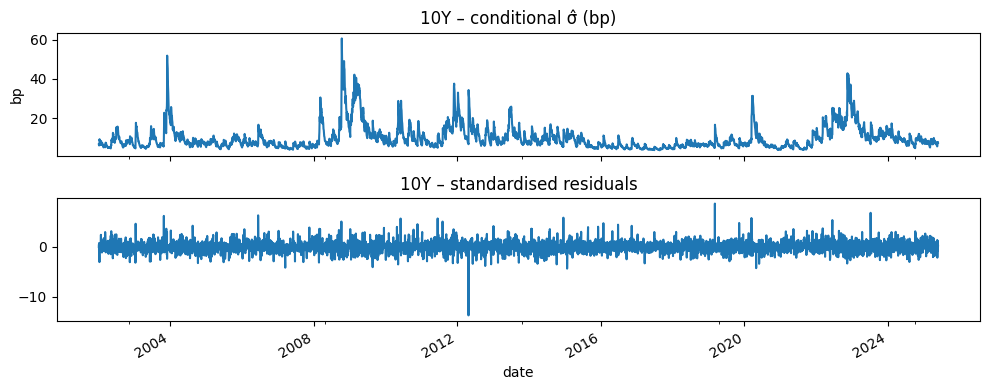

In [27]:
tenor_to_plot = "10Y"
fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)
garch_fits[tenor_to_plot].conditional_volatility.plot(
    ax=ax[0], title=f"{tenor_to_plot} – conditional σ̂ (bp)")
ax[0].set_ylabel("bp")
garch_fits[tenor_to_plot].std_resid.plot(
    ax=ax[1], title=f"{tenor_to_plot} – standardised residuals")
plt.tight_layout(); plt.show()